## Comparative Analysis: Single-hop vs. Multi-hop System Performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from pathlib import Path

# Set up the plotting style for a clean, modern look with white background
plt.style.use('default')  # Reset to clean default style
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': False,
})

print("Loading and processing data files...")

# Initialize lists to store processed data
all_metrics = []

# Define model mappings for cleaner names and specific ordering
model_mapping = {
    'qwen14B': 'Qwen3 (14B)',
    'qwen8B': 'Qwen3 (8B)',
    'qwen4B': 'Qwen3 (4B)',
    'mistral': 'Mistral (7B)',
    'phi4mini': 'Phi-4-mini (4B)',
    'phi-4': 'Phi-4-mini (4B)',  # Added alternative name
    'llama': 'Gemma-3n-E2B'
}

# Define the desired model order (reordered with Mistral before Gemma)
model_order = ['Qwen3 (14B)', 'Qwen3 (8B)', 'Mistral (7B)', 'Gemma-3n-E2B',
               'Qwen3 (4B)', 'Phi-4-mini (4B)']

# Process all CSV files (system metrics) from multiple patterns
patterns = ['[4-5]-doc-*_log.csv', '*single*_log.csv', '*multi*_log.csv']
csv_files = []
for pattern in patterns:
    csv_files.extend(glob.glob(pattern))
csv_files = list(set(csv_files))  # Remove duplicates

# Get corresponding JSON files
json_files = []
for csv_file in csv_files:
    json_file = csv_file.replace('_log.csv', '.json')
    if os.path.exists(json_file):
        json_files.append(json_file)

print(f"Found raw files: {csv_files}")
print(f"Found JSON files: {json_files}")

# Create a mapping of base filenames to their CSV and JSON counterparts
file_pairs = {}
for csv_file in csv_files:
    base_name = os.path.basename(csv_file).replace('_log.csv', '')
    json_file = os.path.join(os.path.dirname(csv_file), base_name + '.json')
    if os.path.exists(json_file):
        file_pairs[base_name] = {'csv': csv_file, 'json': json_file}

print(f"\nProcessing {len(file_pairs)} matching CSV-JSON file pairs:")
for k in file_pairs.keys():
    print(f"- {k}")

# Process each file pair
for base_name, files in file_pairs.items():
    try:
        print(f"\nProcessing {base_name}")

        # Parse filename to extract metadata - improved detection logic
        # Check for explicit indicators of dataset type
        if base_name.startswith('4-doc-multi') or ('_multi_' in base_name.lower() and not '_multi5_' in base_name.lower()):
            dataset_type = 'Multi-hop'
        elif base_name.startswith('5-doc-single') or '_single_' in base_name.lower():
            dataset_type = 'Single-hop'
        else:
            print(f"Skipping {base_name} - unknown dataset type")
            continue

        # Extract model name from the filename
        found_model = False
        base_name_normalized = base_name.lower().replace('-', '').replace('_', '')
        for model_key in model_mapping.keys():
            model_key_normalized = model_key.lower().replace('-', '').replace('_', '')
            if model_key_normalized in base_name_normalized:
                model_name = model_key
                found_model = True
                break

        if not found_model:
            print(f"Skipping {base_name} - unknown model")
            continue

        # Clean model name
        clean_model = model_mapping[model_name]
        print(f"Identified as {clean_model} - {dataset_type}")

        # Load and process CSV data (system metrics)
        csv_df = pd.read_csv(files['csv'])
        print(f"CSV data shape: {csv_df.shape}")

        # Calculate average metrics from CSV
        avg_cpu = csv_df['cpu_pct'].mean()
        avg_ram_mb = csv_df['ram_used_mb'].mean()
        avg_ram_pct = csv_df['ram_pct'].mean()
        avg_vram_mb = csv_df['vram_used_mb'].mean()
        avg_vram_pct = csv_df['vram_pct'].mean()
        avg_power = csv_df['total_gpu_power_w'].mean()

        # Load and process JSON data (response times)
        with open(files['json'], 'r') as f:
            json_data = json.load(f)

        # Extract response times
        response_times = [item['response_time']
                          for item in json_data if 'response_time' in item]
        avg_response_time = np.mean(response_times) if response_times else 0

        # Store the metrics
        metrics_row = {
            'Model': clean_model,
            'Dataset_Type': dataset_type,
            'Avg_CPU_Usage': avg_cpu,
            'Avg_RAM_Usage_MB': avg_ram_mb,
            'Avg_RAM_Usage_PCT': avg_ram_pct,
            'Avg_VRAM_Usage_MB': avg_vram_mb,
            'Avg_VRAM_Usage_PCT': avg_vram_pct,
            'Avg_Power_Consumption_W': avg_power,
            'Avg_Response_Time_S': avg_response_time,
            'File_Base': base_name
        }

        all_metrics.append(metrics_row)
        print(
            f"Processed: {clean_model} - {dataset_type} - Avg Response Time: {avg_response_time:.2f}s")

    except Exception as e:
        print(f"Error processing {base_name}: {str(e)}")

# Create DataFrame
metrics_df = pd.DataFrame(all_metrics)
print(f"\nSuccessfully processed {len(metrics_df)} experiments")
print("\nDataset summary:")
print(metrics_df.groupby(['Model', 'Dataset_Type']).size())

# Verify we have data for plotting
print("\nUnique models found:", metrics_df['Model'].unique())
print("\nUnique dataset types:", metrics_df['Dataset_Type'].unique())

Loading and processing data files...
Found raw files: ['en-en_phi4mini_multi5_bge_log.csv', 'de-es_qwen4B_multi5_bge_log.csv', 'es-en_qwen4B_multi5_bge_log.csv', 'en-en_qwen4B_multi5_bge_log.csv', 'de-en_phi4mini_multi5_bge_log.csv', 'en-en_qwen14B_multi5_bge_log.csv', 'de-de_qwen14B_multi5_bge_log.csv', 'es-de_qwen14B_multi5_bge_log.csv', 'de-en_qwen4B_multi5_bge_log.csv', '5-doc-single_qwen14B_multi5_bge_log.csv', '5-doc-single_llama_multi5_bge_log.csv', '5-doc-single_qwen4B_multi5_bge_log.csv', 'en-es_qwen14B_multi5_bge_log.csv', 'en-es_qwen4B_multi5_bge_log.csv', 'de-es_qwen14B_multi5_bge_log.csv', '5-doc-single_qwen8B_multi5_bge_log.csv', '5-doc_single_qwen4B_gemmaEmb_log.csv', 'de-en_qwen14B_multi5_bge_log.csv', '4-doc-multi_phi-4_multi5_bge_log.csv', 'de-en_gemma_multi5_bge_log.csv', '10-doc-casablanca_qwen4B_multi5_bge_log.csv', '5-doc-single_phi-4_multi5_bge_log.csv', '4-doc-multi_qwen14B_multi5_bge_log.csv', '4-doc-multi_mistral_multi5_bge_log.csv', 'es-de_qwen4B_multi5_bge_l

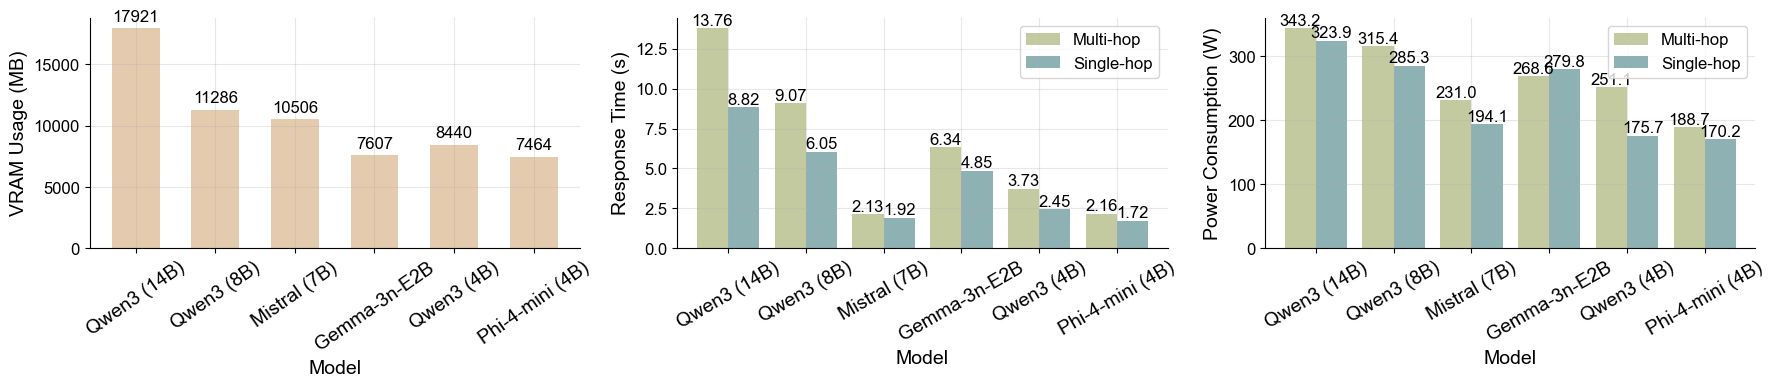


PERFORMANCE SUMMARY STATISTICS
                              Avg_Response_Time_S  Avg_VRAM_Usage_MB  \
Model           Dataset_Type                                           
Gemma-3n-E2B    Multi-hop                    6.34            7612.05   
                Single-hop                   4.85            7601.75   
Mistral (7B)    Multi-hop                    2.13           10513.88   
                Single-hop                   1.92           10497.91   
Phi-4-mini (4B) Multi-hop                    2.16            7471.63   
                Single-hop                   1.72            7455.93   
Qwen3 (14B)     Multi-hop                   13.76           17926.53   
                Single-hop                   8.82           17916.00   
Qwen3 (4B)      Multi-hop                    3.73            8447.93   
                Single-hop                   2.45            8431.80   
Qwen3 (8B)      Multi-hop                    9.07           11293.87   
                Single-hop      

In [2]:
# Create comprehensive performance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
plt.rcParams.update({'font.size': 12})  # Increase base font size

# Define colors for dataset types
colors = {'Single-hop': '#B5BD89', 'Multi-hop': '#729EA1'}

# 1. Average Memory Usage (VRAM) - Combined metric for both query types
ax1 = axes[0]

# Calculate combined average VRAM usage across both query types for each model
vram_combined = metrics_df.groupby(
    'Model')['Avg_VRAM_Usage_MB'].mean().reset_index()
# Reorder based on model_order
vram_combined = vram_combined.set_index('Model')
vram_combined = vram_combined.reindex(
    [model for model in model_order if model in vram_combined.index])

# Plot the combined VRAM usage as a single bar per model
bars = ax1.bar(vram_combined.index, vram_combined['Avg_VRAM_Usage_MB'],
               color='#DFBE99', width=0.6, alpha=0.8)
ax1.set_ylabel('VRAM Usage (MB)', fontsize=14)
ax1.set_xlabel('Model', fontsize=14)
ax1.tick_params(axis='x', labelsize=14, rotation=35)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)

# 2. Average Response Time
ax2 = axes[1]
pivot_response = metrics_df.pivot_table(values='Avg_Response_Time_S',
                                        index='Model',
                                        columns='Dataset_Type',
                                        aggfunc='mean')
# Reorder based on model_order
pivot_response = pivot_response.reindex(
    [model for model in model_order if model in pivot_response.index])

pivot_response.plot(kind='bar', ax=ax2, color=[colors['Single-hop'], colors['Multi-hop']],
                    width=0.8, alpha=0.8)
ax2.set_ylabel('Response Time (s)', fontsize=14)
ax2.set_xlabel('Model', fontsize=14)
ax2.legend(loc='upper right', fontsize=12)
ax2.tick_params(axis='x', labelsize=14, rotation=30)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', fontsize=12)

# 3. Average Power Consumption
ax3 = axes[2]
pivot_power = metrics_df.pivot_table(values='Avg_Power_Consumption_W',
                                     index='Model',
                                     columns='Dataset_Type',
                                     aggfunc='mean')
# Reorder based on model_order
pivot_power = pivot_power.reindex(
    [model for model in model_order if model in pivot_power.index])

pivot_power.plot(kind='bar', ax=ax3, color=[colors['Single-hop'], colors['Multi-hop']],
                 width=0.8, alpha=0.8)
ax3.set_ylabel('Power Consumption (W)', fontsize=14)
ax3.set_xlabel('Model', fontsize=14)
ax3.legend(loc='upper right', fontsize=12)
ax3.tick_params(axis='x', labelsize=14, rotation=30)
ax3.tick_params(axis='y', labelsize=12)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f', fontsize=12)

plt.tight_layout()

# Save the figure as PDF with high quality
plt.savefig('performance_comparison.pdf',
            format='pdf', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

# Display summary statistics
print("\n" + "="*80)
print("PERFORMANCE SUMMARY STATISTICS")
print("="*80)
summary_stats = metrics_df.groupby(['Model', 'Dataset_Type']).agg({
    'Avg_Response_Time_S': 'mean',
    'Avg_VRAM_Usage_MB': 'mean',
    'Avg_Power_Consumption_W': 'mean',
    'Avg_CPU_Usage': 'mean'
}).round(2)

print(summary_stats)